[KRITIK AGARWAL 19BBTCS067](https://github.com/Kritik007)

Deep Learning Lab Experiment 9

Generative Adversarial Network: Write a program to implement the generative adversarial networks

---

Generative Adversarial Networks(GAN in short) is an advancement in the field of Machine Learning which is capable of generating new data samples including Text, Audio, Images, Videos, etc. using previously available data. GANs consist of two Artificial Neural Networks or Convolution Neural Networks models namely Generator and Discriminator which are trained against each other (and thus Adversarial). 


---

In [1]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

In [2]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print("\n\n")
print(X_train.shape)

4422102/4422102 [==============================] - 0s 0us/step



(60000, 28, 28, 1)


In [3]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [4]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

In [5]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [6]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [7]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [8]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(learning_rate=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [9]:
discriminator = define_discriminator()

In [10]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [11]:
generator = define_generator(100)

In [12]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [13]:
gan_model = define_gan(generator, discriminator)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

2/2 [==============================] - 0s 19ms/step
>1, dr[0.752,0.484], df[0.698,0.125], g[0.691,0.781]
2/2 [==============================] - 0s 15ms/step
>2, dr[0.118,1.000], df[0.707,0.000], g[0.682,1.000]
2/2 [==============================] - 0s 15ms/step
>3, dr[0.039,1.000], df[0.716,0.000], g[0.674,1.000]
2/2 [==============================] - 0s 15ms/step
>4, dr[0.018,1.000], df[0.729,0.000], g[0.663,1.000]
2/2 [==============================] - 0s 19ms/step
>5, dr[0.020,1.000], df[0.747,0.000], g[0.650,1.000]
2/2 [==============================] - 0s 19ms/step
>6, dr[0.013,1.000], df[0.770,0.000], g[0.632,1.000]
2/2 [==============================] - 0s 20ms/step
>7, dr[0.011,1.000], df[0.794,0.000], g[0.616,1.000]
2/2 [==============================] - 0s 33ms/step
>8, dr[0.013,1.000], df[0.826,0.000], g[0.604,1.000]
2/2 [==============================] - 0s 18ms/step
>9, dr[0.011,1.000], df[0.844,0.000], g[0.599,1.000]
2/2 [==============================] - 0s 21ms/step
>10

>Saved: model_0937.h5
2/2 [==============================] - 0s 13ms/step
>938, dr[0.983,0.672], df[0.238,0.969], g[2.853,0.016]
2/2 [==============================] - 0s 16ms/step
>939, dr[0.260,0.859], df[0.224,0.938], g[3.344,0.016]
2/2 [==============================] - 0s 13ms/step
>940, dr[0.145,0.938], df[0.250,0.891], g[3.821,0.016]
2/2 [==============================] - 0s 12ms/step
>941, dr[0.197,0.875], df[0.163,0.938], g[3.853,0.000]
2/2 [==============================] - 0s 15ms/step
>942, dr[0.252,0.906], df[0.204,0.953], g[3.989,0.000]
2/2 [==============================] - 0s 12ms/step
>943, dr[0.360,0.844], df[0.350,0.875], g[4.561,0.000]
2/2 [==============================] - 0s 13ms/step
>944, dr[0.568,0.703], df[0.174,0.969], g[3.432,0.016]
2/2 [==============================] - 0s 15ms/step
>945, dr[0.129,0.922], df[0.204,0.891], g[4.142,0.000]
2/2 [==============================] - 0s 12ms/step
>946, dr[0.262,0.875], df[0.169,0.953], g[3.973,0.000]
2/2 [==========

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


>Saved: model_1874.h5
2/2 [==============================] - 0s 13ms/step
>1875, dr[0.441,0.734], df[0.333,0.922], g[2.308,0.000]
2/2 [==============================] - 0s 13ms/step
>1876, dr[0.499,0.719], df[0.389,0.875], g[2.325,0.000]
2/2 [==============================] - 0s 17ms/step
>1877, dr[0.416,0.766], df[0.244,0.984], g[2.298,0.000]
2/2 [==============================] - 0s 13ms/step
>1878, dr[0.478,0.734], df[0.347,0.906], g[2.106,0.016]
2/2 [==============================] - 0s 14ms/step
>1879, dr[0.363,0.828], df[0.461,0.812], g[2.516,0.000]
2/2 [==============================] - 0s 13ms/step
>1880, dr[0.566,0.688], df[0.398,0.844], g[2.605,0.000]
2/2 [==============================] - 0s 13ms/step
>1881, dr[0.606,0.734], df[0.269,0.953], g[2.123,0.031]
2/2 [==============================] - 0s 12ms/step
>1882, dr[0.452,0.797], df[0.471,0.766], g[2.254,0.016]
2/2 [==============================] - 0s 11ms/step
>1883, dr[0.391,0.750], df[0.213,0.953], g[2.242,0.016]
2/2 [=

>Saved: model_2811.h5
2/2 [==============================] - 0s 17ms/step
>2812, dr[0.536,0.594], df[0.388,0.859], g[2.201,0.031]
2/2 [==============================] - 0s 14ms/step
>2813, dr[0.401,0.781], df[0.249,0.984], g[2.047,0.016]
2/2 [==============================] - 0s 18ms/step
>2814, dr[0.329,0.781], df[0.295,0.922], g[2.312,0.016]
2/2 [==============================] - 0s 12ms/step
>2815, dr[0.504,0.688], df[0.274,0.953], g[2.238,0.031]
2/2 [==============================] - 0s 16ms/step
>2816, dr[0.433,0.750], df[0.376,0.875], g[2.141,0.000]
2/2 [==============================] - 0s 13ms/step
>2817, dr[0.513,0.688], df[0.313,0.891], g[2.017,0.016]
2/2 [==============================] - 0s 14ms/step
>2818, dr[0.556,0.672], df[0.478,0.875], g[2.076,0.047]
2/2 [==============================] - 0s 12ms/step
>2819, dr[0.389,0.781], df[0.239,0.984], g[2.118,0.062]
2/2 [==============================] - 0s 12ms/step
>2820, dr[0.487,0.734], df[0.379,0.875], g[1.954,0.062]
2/2 [=

>Saved: model_3748.h5
2/2 [==============================] - 0s 13ms/step
>3749, dr[0.432,0.750], df[0.328,0.906], g[1.767,0.094]
2/2 [==============================] - 0s 17ms/step
>3750, dr[0.455,0.734], df[0.338,0.953], g[1.994,0.031]
2/2 [==============================] - 0s 14ms/step
>3751, dr[0.500,0.672], df[0.324,0.938], g[1.862,0.000]
2/2 [==============================] - 0s 20ms/step
>3752, dr[0.422,0.750], df[0.365,0.922], g[1.782,0.016]
2/2 [==============================] - 0s 14ms/step
>3753, dr[0.462,0.719], df[0.500,0.859], g[1.913,0.000]
2/2 [==============================] - 0s 12ms/step
>3754, dr[0.567,0.641], df[0.356,0.906], g[1.844,0.016]
2/2 [==============================] - 0s 18ms/step
>3755, dr[0.462,0.688], df[0.368,0.844], g[1.923,0.016]
2/2 [==============================] - 0s 19ms/step
>3756, dr[0.671,0.594], df[0.353,0.906], g[1.684,0.047]
2/2 [==============================] - 0s 16ms/step
>3757, dr[0.553,0.672], df[0.538,0.891], g[1.707,0.062]
2/2 [=

>Saved: model_4685.h5
2/2 [==============================] - 0s 18ms/step
>4686, dr[0.524,0.625], df[0.440,0.844], g[1.561,0.016]
2/2 [==============================] - 0s 20ms/step
>4687, dr[0.690,0.594], df[0.406,0.859], g[1.459,0.031]
2/2 [==============================] - 0s 19ms/step
>4688, dr[0.399,0.781], df[0.448,0.859], g[1.592,0.078]
2/2 [==============================] - 0s 21ms/step
>4689, dr[0.500,0.672], df[0.479,0.922], g[1.713,0.047]
2/2 [==============================] - 0s 14ms/step
>4690, dr[0.623,0.594], df[0.389,0.891], g[1.460,0.141]
2/2 [==============================] - 0s 18ms/step
>4691, dr[0.377,0.781], df[0.427,0.875], g[1.617,0.125]
2/2 [==============================] - 0s 20ms/step
>4692, dr[0.427,0.719], df[0.473,0.844], g[1.612,0.047]
2/2 [==============================] - 0s 13ms/step
>4693, dr[0.621,0.625], df[0.318,0.953], g[1.557,0.078]
2/2 [==============================] - 0s 13ms/step
>4694, dr[0.527,0.688], df[0.523,0.844], g[1.555,0.031]
2/2 [=

>Saved: model_5622.h5
2/2 [==============================] - 0s 12ms/step
>5623, dr[0.645,0.531], df[0.578,0.828], g[1.354,0.078]
2/2 [==============================] - 0s 15ms/step
>5624, dr[0.580,0.594], df[0.538,0.781], g[1.421,0.062]
2/2 [==============================] - 0s 16ms/step
>5625, dr[0.492,0.672], df[0.381,0.906], g[1.271,0.047]
2/2 [==============================] - 0s 21ms/step
>5626, dr[0.493,0.672], df[0.441,0.859], g[1.316,0.094]
2/2 [==============================] - 0s 15ms/step
>5627, dr[0.630,0.547], df[0.594,0.766], g[1.281,0.109]
2/2 [==============================] - 0s 14ms/step
>5628, dr[0.593,0.531], df[0.425,0.859], g[1.301,0.094]
2/2 [==============================] - 0s 21ms/step
>5629, dr[0.594,0.531], df[0.685,0.781], g[1.374,0.031]
2/2 [==============================] - 0s 15ms/step
>5630, dr[0.527,0.672], df[0.440,0.812], g[1.346,0.047]
2/2 [==============================] - 0s 20ms/step
>5631, dr[0.550,0.625], df[0.519,0.828], g[1.510,0.031]
2/2 [=

>Saved: model_6559.h5
2/2 [==============================] - 0s 12ms/step
>6560, dr[0.635,0.594], df[0.471,0.797], g[1.308,0.062]
2/2 [==============================] - 0s 11ms/step
>6561, dr[0.483,0.719], df[0.612,0.828], g[1.279,0.062]
2/2 [==============================] - 0s 14ms/step
>6562, dr[0.541,0.672], df[0.445,0.891], g[1.206,0.156]
2/2 [==============================] - 0s 13ms/step
>6563, dr[0.676,0.578], df[0.596,0.766], g[1.126,0.156]
2/2 [==============================] - 0s 12ms/step
>6564, dr[0.586,0.641], df[0.620,0.750], g[1.146,0.094]
2/2 [==============================] - 0s 13ms/step
>6565, dr[0.653,0.578], df[0.570,0.734], g[1.164,0.047]
2/2 [==============================] - 0s 13ms/step
>6566, dr[0.466,0.688], df[0.561,0.766], g[1.249,0.094]
2/2 [==============================] - 0s 16ms/step
>6567, dr[0.631,0.609], df[0.530,0.750], g[1.382,0.109]
2/2 [==============================] - 0s 14ms/step
>6568, dr[0.697,0.500], df[0.548,0.797], g[1.245,0.078]
2/2 [=

>Saved: model_7496.h5
2/2 [==============================] - 0s 16ms/step
>7497, dr[0.654,0.531], df[0.583,0.781], g[1.251,0.109]
2/2 [==============================] - 0s 14ms/step
>7498, dr[0.586,0.641], df[0.567,0.781], g[1.179,0.094]
2/2 [==============================] - 0s 13ms/step
>7499, dr[0.603,0.516], df[0.547,0.812], g[1.039,0.156]
2/2 [==============================] - 0s 15ms/step
>7500, dr[0.669,0.531], df[0.635,0.703], g[1.191,0.078]
2/2 [==============================] - 0s 14ms/step
>7501, dr[0.633,0.562], df[0.605,0.734], g[1.148,0.109]
2/2 [==============================] - 0s 24ms/step
>7502, dr[0.535,0.703], df[0.485,0.859], g[1.134,0.109]
2/2 [==============================] - 0s 14ms/step
>7503, dr[0.650,0.516], df[0.564,0.719], g[1.155,0.141]
2/2 [==============================] - 0s 20ms/step
>7504, dr[0.640,0.516], df[0.581,0.766], g[1.043,0.203]
2/2 [==============================] - 0s 31ms/step
>7505, dr[0.587,0.578], df[0.514,0.812], g[1.218,0.094]
2/2 [=

>Saved: model_8433.h5
2/2 [==============================] - 0s 15ms/step
>8434, dr[0.688,0.531], df[0.567,0.734], g[1.072,0.109]
2/2 [==============================] - 0s 13ms/step
>8435, dr[0.611,0.641], df[0.557,0.828], g[1.000,0.172]
2/2 [==============================] - 0s 18ms/step
>8436, dr[0.542,0.609], df[0.635,0.672], g[0.975,0.156]
2/2 [==============================] - 0s 16ms/step
>8437, dr[0.541,0.656], df[0.565,0.750], g[0.946,0.219]
2/2 [==============================] - 0s 20ms/step
>8438, dr[0.522,0.656], df[0.671,0.641], g[1.032,0.125]
2/2 [==============================] - 0s 12ms/step
>8439, dr[0.544,0.625], df[0.534,0.828], g[1.076,0.125]
2/2 [==============================] - 0s 18ms/step
>8440, dr[0.603,0.594], df[0.561,0.797], g[0.975,0.203]
2/2 [==============================] - 0s 16ms/step
>8441, dr[0.655,0.562], df[0.629,0.656], g[1.015,0.156]
2/2 [==============================] - 0s 15ms/step
>8442, dr[0.548,0.641], df[0.567,0.719], g[1.142,0.094]
2/2 [=

>Saved: model_9370.h5
2/2 [==============================] - 0s 23ms/step
>9371, dr[0.605,0.562], df[0.626,0.703], g[0.982,0.172]
2/2 [==============================] - 0s 20ms/step
>9372, dr[0.733,0.422], df[0.660,0.672], g[1.046,0.109]
2/2 [==============================] - 0s 14ms/step
>9373, dr[0.699,0.453], df[0.584,0.781], g[0.963,0.188]
2/2 [==============================] - 0s 16ms/step
>9374, dr[0.739,0.516], df[0.601,0.781], g[0.976,0.188]
2/2 [==============================] - 0s 12ms/step
>9375, dr[0.726,0.453], df[0.636,0.766], g[1.028,0.141]
2/2 [==============================] - 0s 19ms/step
>9376, dr[0.714,0.453], df[0.548,0.781], g[1.013,0.281]
2/2 [==============================] - 0s 20ms/step
>9377, dr[0.643,0.562], df[0.701,0.594], g[0.955,0.234]
2/2 [==============================] - 0s 14ms/step
>9378, dr[0.627,0.547], df[0.600,0.719], g[1.023,0.109]
2/2 [==============================] - 0s 19ms/step
>9379, dr[0.724,0.453], df[0.609,0.688], g[1.017,0.141]
2/2 [=

>Saved: model_10307.h5
2/2 [==============================] - 0s 17ms/step
>10308, dr[0.643,0.516], df[0.666,0.719], g[1.045,0.203]
2/2 [==============================] - 0s 16ms/step
>10309, dr[0.706,0.469], df[0.642,0.781], g[1.019,0.109]
2/2 [==============================] - 0s 19ms/step
>10310, dr[0.591,0.672], df[0.597,0.703], g[0.970,0.188]
2/2 [==============================] - 0s 13ms/step
>10311, dr[0.673,0.516], df[0.722,0.656], g[0.929,0.234]
2/2 [==============================] - 0s 15ms/step
>10312, dr[0.746,0.422], df[0.676,0.656], g[0.946,0.172]
2/2 [==============================] - 0s 13ms/step
>10313, dr[0.663,0.547], df[0.602,0.734], g[0.953,0.125]
2/2 [==============================] - 0s 14ms/step
>10314, dr[0.596,0.531], df[0.653,0.672], g[1.025,0.125]
2/2 [==============================] - 0s 14ms/step
>10315, dr[0.644,0.516], df[0.556,0.766], g[0.978,0.109]
2/2 [==============================] - 0s 13ms/step
>10316, dr[0.602,0.609], df[0.589,0.719], g[0.985,0.1

>Saved: model_11244.h5
2/2 [==============================] - 0s 18ms/step
>11245, dr[0.662,0.547], df[0.643,0.625], g[0.919,0.203]
2/2 [==============================] - 0s 14ms/step
>11246, dr[0.643,0.531], df[0.648,0.625], g[0.963,0.203]
2/2 [==============================] - 0s 15ms/step
>11247, dr[0.644,0.562], df[0.651,0.750], g[0.940,0.156]
2/2 [==============================] - 0s 16ms/step
>11248, dr[0.569,0.625], df[0.592,0.688], g[0.919,0.266]
2/2 [==============================] - 0s 16ms/step
>11249, dr[0.616,0.562], df[0.669,0.641], g[1.010,0.297]
2/2 [==============================] - 0s 12ms/step
>11250, dr[0.603,0.625], df[0.590,0.812], g[0.915,0.266]
2/2 [==============================] - 0s 13ms/step
>11251, dr[0.592,0.641], df[0.728,0.656], g[1.067,0.141]
2/2 [==============================] - 0s 14ms/step
>11252, dr[0.602,0.594], df[0.566,0.797], g[1.031,0.125]
2/2 [==============================] - 0s 22ms/step
>11253, dr[0.704,0.547], df[0.545,0.797], g[1.038,0.1

>Saved: model_12181.h5
2/2 [==============================] - 0s 13ms/step
>12182, dr[0.633,0.562], df[0.698,0.656], g[1.069,0.078]
2/2 [==============================] - 0s 23ms/step
>12183, dr[0.604,0.625], df[0.579,0.781], g[0.913,0.188]
2/2 [==============================] - 0s 17ms/step
>12184, dr[0.630,0.562], df[0.620,0.734], g[0.960,0.203]
2/2 [==============================] - 0s 14ms/step
>12185, dr[0.612,0.641], df[0.573,0.797], g[1.024,0.188]
2/2 [==============================] - 0s 12ms/step
>12186, dr[0.614,0.562], df[0.646,0.625], g[0.996,0.141]
2/2 [==============================] - 0s 14ms/step
>12187, dr[0.628,0.547], df[0.601,0.734], g[0.990,0.203]
2/2 [==============================] - 0s 14ms/step
>12188, dr[0.581,0.672], df[0.637,0.594], g[0.992,0.094]
2/2 [==============================] - 0s 14ms/step
>12189, dr[0.616,0.562], df[0.692,0.609], g[0.998,0.109]
2/2 [==============================] - 0s 13ms/step
>12190, dr[0.569,0.625], df[0.623,0.703], g[1.035,0.1

>Saved: model_13118.h5
2/2 [==============================] - 0s 17ms/step
>13119, dr[0.654,0.562], df[0.606,0.734], g[0.947,0.188]
2/2 [==============================] - 0s 12ms/step
>13120, dr[0.698,0.500], df[0.619,0.688], g[1.031,0.141]
2/2 [==============================] - 0s 17ms/step
>13121, dr[0.608,0.578], df[0.605,0.750], g[0.953,0.203]
2/2 [==============================] - 0s 14ms/step
>13122, dr[0.650,0.562], df[0.656,0.719], g[0.943,0.141]
2/2 [==============================] - 0s 12ms/step
>13123, dr[0.659,0.625], df[0.690,0.656], g[0.965,0.094]
2/2 [==============================] - 0s 14ms/step
>13124, dr[0.651,0.594], df[0.680,0.688], g[0.951,0.234]
2/2 [==============================] - 0s 14ms/step
>13125, dr[0.607,0.547], df[0.591,0.828], g[1.026,0.062]
2/2 [==============================] - 0s 15ms/step
>13126, dr[0.647,0.609], df[0.568,0.828], g[0.972,0.188]
2/2 [==============================] - 0s 12ms/step
>13127, dr[0.530,0.672], df[0.632,0.781], g[0.939,0.2

>Saved: model_14055.h5
2/2 [==============================] - 0s 17ms/step
>14056, dr[0.618,0.609], df[0.571,0.781], g[0.919,0.219]
2/2 [==============================] - 0s 20ms/step
>14057, dr[0.632,0.578], df[0.710,0.656], g[1.027,0.172]
2/2 [==============================] - 0s 14ms/step
>14058, dr[0.637,0.547], df[0.675,0.656], g[1.047,0.141]
2/2 [==============================] - 0s 15ms/step
>14059, dr[0.720,0.484], df[0.578,0.734], g[0.992,0.188]
2/2 [==============================] - 0s 13ms/step
>14060, dr[0.681,0.453], df[0.649,0.688], g[0.949,0.219]
2/2 [==============================] - 0s 27ms/step
>14061, dr[0.591,0.625], df[0.661,0.766], g[1.007,0.156]
2/2 [==============================] - 0s 16ms/step
>14062, dr[0.655,0.547], df[0.619,0.703], g[0.952,0.188]
2/2 [==============================] - 0s 16ms/step
>14063, dr[0.639,0.547], df[0.622,0.750], g[0.874,0.266]
2/2 [==============================] - 0s 15ms/step
>14064, dr[0.633,0.578], df[0.679,0.766], g[0.942,0.1

>Saved: model_14992.h5
2/2 [==============================] - 0s 22ms/step
>14993, dr[0.566,0.625], df[0.636,0.672], g[0.986,0.188]
2/2 [==============================] - 0s 25ms/step
>14994, dr[0.618,0.625], df[0.729,0.594], g[0.999,0.219]
2/2 [==============================] - 0s 19ms/step
>14995, dr[0.599,0.625], df[0.648,0.672], g[1.074,0.094]
2/2 [==============================] - 0s 18ms/step
>14996, dr[0.660,0.516], df[0.578,0.797], g[0.944,0.188]
2/2 [==============================] - 0s 17ms/step
>14997, dr[0.775,0.484], df[0.569,0.812], g[0.934,0.219]
2/2 [==============================] - 0s 15ms/step
>14998, dr[0.728,0.469], df[0.708,0.703], g[0.957,0.141]
2/2 [==============================] - 0s 20ms/step
>14999, dr[0.713,0.438], df[0.629,0.656], g[0.972,0.125]
2/2 [==============================] - 0s 14ms/step
>15000, dr[0.612,0.594], df[0.557,0.734], g[0.977,0.094]
2/2 [==============================] - 0s 14ms/step
>15001, dr[0.638,0.547], df[0.603,0.672], g[0.927,0.2

>Saved: model_15929.h5
2/2 [==============================] - 0s 21ms/step
>15930, dr[0.674,0.516], df[0.659,0.641], g[1.011,0.172]
2/2 [==============================] - 0s 19ms/step
>15931, dr[0.572,0.656], df[0.648,0.641], g[0.999,0.234]
2/2 [==============================] - 0s 13ms/step
>15932, dr[0.633,0.625], df[0.652,0.703], g[1.038,0.078]
2/2 [==============================] - 0s 12ms/step
>15933, dr[0.695,0.500], df[0.665,0.656], g[0.999,0.219]
2/2 [==============================] - 0s 12ms/step
>15934, dr[0.663,0.516], df[0.550,0.859], g[0.970,0.141]
2/2 [==============================] - 0s 13ms/step
>15935, dr[0.665,0.578], df[0.606,0.766], g[0.944,0.203]
2/2 [==============================] - 0s 15ms/step
>15936, dr[0.704,0.562], df[0.664,0.641], g[0.908,0.219]
2/2 [==============================] - 0s 16ms/step
>15937, dr[0.592,0.656], df[0.680,0.578], g[1.028,0.125]
2/2 [==============================] - 0s 13ms/step
>15938, dr[0.612,0.594], df[0.637,0.688], g[0.916,0.2

>Saved: model_16866.h5
2/2 [==============================] - 0s 19ms/step
>16867, dr[0.603,0.594], df[0.647,0.656], g[0.915,0.266]
2/2 [==============================] - 0s 13ms/step
>16868, dr[0.562,0.703], df[0.605,0.766], g[0.921,0.219]
2/2 [==============================] - 0s 11ms/step
>16869, dr[0.581,0.609], df[0.738,0.578], g[0.948,0.266]
2/2 [==============================] - 0s 12ms/step
>16870, dr[0.586,0.625], df[0.699,0.641], g[0.986,0.203]
2/2 [==============================] - 0s 16ms/step
>16871, dr[0.660,0.531], df[0.622,0.703], g[1.011,0.141]
2/2 [==============================] - 0s 15ms/step
>16872, dr[0.640,0.594], df[0.584,0.734], g[0.952,0.234]
2/2 [==============================] - 0s 18ms/step
>16873, dr[0.602,0.625], df[0.613,0.719], g[0.962,0.203]
2/2 [==============================] - 0s 15ms/step
>16874, dr[0.692,0.516], df[0.684,0.750], g[0.975,0.125]
2/2 [==============================] - 0s 15ms/step
>16875, dr[0.591,0.656], df[0.577,0.734], g[1.002,0.2

>Saved: model_17803.h5
2/2 [==============================] - 0s 15ms/step
>17804, dr[0.702,0.531], df[0.556,0.812], g[0.948,0.156]
2/2 [==============================] - 0s 14ms/step
>17805, dr[0.656,0.469], df[0.582,0.750], g[0.885,0.297]
2/2 [==============================] - 0s 18ms/step
>17806, dr[0.627,0.625], df[0.670,0.703], g[1.037,0.125]
2/2 [==============================] - 0s 13ms/step
>17807, dr[0.684,0.531], df[0.648,0.703], g[1.045,0.172]
2/2 [==============================] - 0s 19ms/step
>17808, dr[0.641,0.578], df[0.553,0.734], g[0.972,0.188]
2/2 [==============================] - 0s 18ms/step
>17809, dr[0.751,0.422], df[0.577,0.734], g[1.012,0.109]
2/2 [==============================] - 0s 16ms/step
>17810, dr[0.603,0.625], df[0.672,0.688], g[0.967,0.172]
2/2 [==============================] - 0s 16ms/step
>17811, dr[0.586,0.656], df[0.650,0.719], g[0.888,0.266]
2/2 [==============================] - 0s 14ms/step
>17812, dr[0.637,0.594], df[0.664,0.656], g[0.966,0.1

>Saved: model_18740.h5


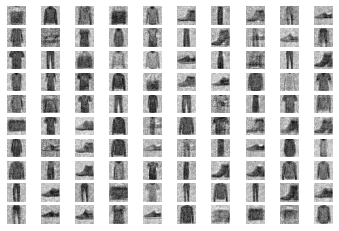

In [15]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

4/4 [==============================] - 0s 7ms/step


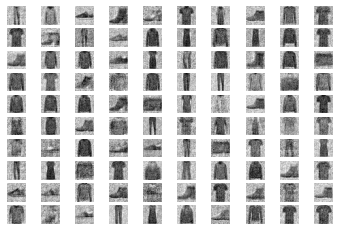

In [16]:
model = load_model('/content/model_18740.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)

In [17]:
!ls '/content/'

model_0937.h5	model_14055.h5	model_18740.h5	model_5622.h5  sample_data
model_10307.h5	model_14992.h5	model_1874.h5	model_6559.h5
model_11244.h5	model_15929.h5	model_2811.h5	model_7496.h5
model_12181.h5	model_16866.h5	model_3748.h5	model_8433.h5
model_13118.h5	model_17803.h5	model_4685.h5	model_9370.h5
